In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score

pd.set_option('display.max_columns', None)

In [2]:
# Import dataset
df = pd.read_csv("train.csv")
df.MasVnrArea.fillna(0.0, inplace=True)

In [3]:
# Define sections of numerical attributes
lot = [
    "LotFrontage",
    "LotArea"
]

major = [
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
]

basement = [
    "BsmtFinSF1",
    "BsmtUnfSF",
    "TotalBsmtSF"
]

floors = [
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea"
]

rooms = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
]

bathrooms = [
    "BsmtFullBath",
    "FullBath",
    "HalfBath",
]

garage = [
    "GarageYrBlt",
    "GarageCars",
]
    
outdoors = [
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "ScreenPorch",
    "PoolArea",
    "MasVnrArea"
]

year = [
    "GarageYrBlt",
    "YearBuilt",
    "YearRemodAdd",
]

In [4]:
#This function will modify the dataset and remove pre-decieded features (as shown in ML_Final_EDA)
def modify_dataset(data):
    
    #Delete the following columns
    data = data.drop(
        ['GarageArea', 'BsmtHalfBath', 'MiscVal', 'MoSold',
        'YrSold', 'BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 
        'Utilities', 'Exterior2nd'],
        axis = 1)

    #Combine GarageCars == 3 and GarageCars == 4
    data.GarageCars = data.GarageCars.map(lambda x: 3 if (x == 4) else x)
    
    #Fill Nans in GarageYrBlt with median year
    data.GarageYrBlt = data.GarageYrBlt.fillna(data.GarageYrBlt.median())

    #Combine KitchenAbvGr 1 and 0 AND 2 and 3 such that it is binary
    data.KitchenAbvGr = data.KitchenAbvGr.map(lambda x: 0 if (x == 1) else x)
    data.KitchenAbvGr = data.KitchenAbvGr.map(lambda x: 1 if (x == 2 or x == 3) else x)
    
    #Make Pool Area binary (x>0 or x==0)--> 1 if they have pool else 0
    data.PoolArea = data.PoolArea.map(lambda x: 1 if (x>0) else x)

    return data

In [5]:
df_test = modify_dataset(df)
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,150,856,GasA,Ex,Y,SBrkr,856,854,1710,1,2,1,3,0,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,284,1262,GasA,Ex,Y,SBrkr,1262,0,1262,0,2,0,3,0,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,434,920,GasA,Ex,Y,SBrkr,920,866,1786,1,2,1,3,0,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,540,756,GasA,Gd,Y,SBrkr,961,756,1717,1,1,0,3,0,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,490,1145,GasA,Ex,Y,SBrkr,1145,1053,2198,1,2,1,4,0,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,WD,Normal,250000


#### Go through these groups and do Vector Quantization:


    lot, 
    major, 
    basement,
    floors,
    rooms,
    bathrooms,
    garage,
    outdoors,
    year


In [6]:
# Fill nans, get dummies, center, and scale data
df_num = pd.get_dummies(df_test)
del df_num["Id"]
y = df_num.SalePrice
del df_num["SalePrice"]
X = df_num
X.LotFrontage = X.LotFrontage.fillna(X.LotFrontage.median())
X.MasVnrArea = X.MasVnrArea.fillna(X.MasVnrArea.median())
X = (X - X.mean())/X.std()

In [7]:
def view_clusters(data, section, k):
    """
    Takes data, section (list of column names), and k (number of clusters)
    prints a 2-d PCA representation 
    does k-means clustering on the PCA'd data
    returns the labels of the clustering
    """
    pca = PCA()
    temp = pd.DataFrame(pca.fit_transform(data[section]))
    km = KMeans(n_clusters=k)
    km.fit(temp)
    labels = km.labels_
    for i in np.unique(km.labels_):
        plt.scatter(temp[labels == i][0], temp[labels == i][1], alpha = 0.3)
    return km.labels_

In [8]:
def show_elbow_CH(data):
    """
    Takes a data set and preforms kMeans clustering on it with k= 2 through 12
    Plot the graph of the scores vs k values
    return a list of scores by k values
    """
    scores = []
    for i in range(2, 12):
        km = KMeans(n_clusters=i)
        km.fit(data)
        scores.append([calinski_harabaz_score(data, np.array(km.labels_)), i])
        
    scores = pd.DataFrame(scores)
    plt.scatter(scores[1], scores[0])
    plt.xlabel("k Clusters")
    plt.ylabel("CH Score")
    plt.show()
    return scores

In [9]:
def describe_clusters(data, section, labels):
    """
    Takes data, columsn you are interested in, and cluster lables
    prints the columns you are interested in split by the labels
    prints the SalePrice splitby labels
    """
    for i in np.unique(labels):
        print data[section][labels==i].mean()
    print pd.DataFrame([data.SalePrice, labels]).T.groupby("Unnamed 0").mean()
    return True

In [10]:
def cluster_analysis(norm_data, reg_data, section, k):
    """
    Takes data for clustering, data for description, the columsn you are interested in, and the number of clusters
    Plots an elbow graph for selection of k
    Obtains cluster labels, plots 2-d PCA of clusters 
    describes columns of interest split by cluster labels
    returns cluster labels
    """
    show_elbow_CH(norm_data[section])
    labels = view_clusters(norm_data, section, k)
    describe_clusters(reg_data, section, labels)
    return labels

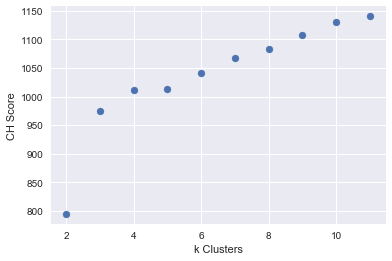

BsmtFinSF1     1017.886889
BsmtUnfSF       337.521851
TotalBsmtSF    1400.473008
dtype: float64
BsmtFinSF1       70.496599
BsmtUnfSF      1260.884354
TotalBsmtSF    1352.289116
dtype: float64
BsmtFinSF1     297.335907
BsmtUnfSF      419.787645
TotalBsmtSF    774.118404
dtype: float64
           SalePrice
Unnamed 0           
0             229872
1             206929
2             146573


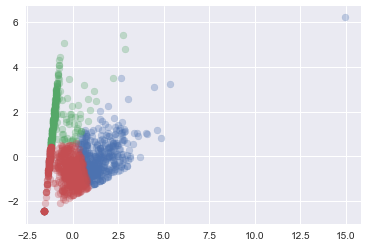

In [11]:
basement_clusters = cluster_analysis(X, df, basement, 3)

# There seem to be three basement clusters:
-  Finished basements (high BsmtFinSF1, low BsmtUnfSF)
-  Unfinished basements (high BsmtUnfSF, low BsmtFinSF1)
-  Small basements (low TotalBsmtSF)

Finished basements have a highest price, small basements have lowest price

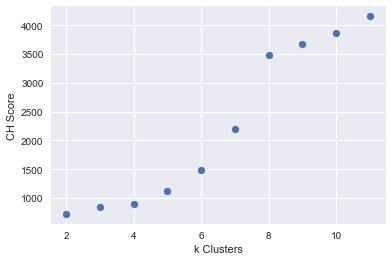

BsmtFullBath    0.000000
FullBath        2.030303
HalfBath        0.000000
dtype: float64
BsmtFullBath    1.078947
FullBath        0.934211
HalfBath        1.039474
dtype: float64
BsmtFullBath    0.000000
FullBath        2.058296
HalfBath        1.013453
dtype: float64
BsmtFullBath    1.009346
FullBath        0.985981
HalfBath        0.000000
dtype: float64
BsmtFullBath    0.0
FullBath        1.0
HalfBath        0.0
dtype: float64
BsmtFullBath    1.038889
FullBath        2.038889
HalfBath        0.000000
dtype: float64
BsmtFullBath    1.014925
FullBath        2.037313
HalfBath        1.014925
dtype: float64
BsmtFullBath    0.000000
FullBath        0.991228
HalfBath        1.035088
dtype: float64
           SalePrice
Unnamed 0           
0             177033
1             180790
2             219432
3             137004
4             114119
5             240212
6             269860
7             148384


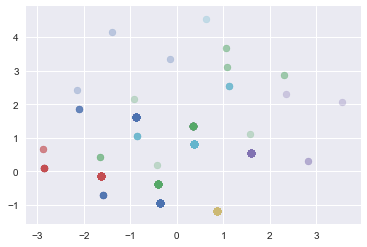

In [12]:
bathrooms_clusters = cluster_analysis(X, df, bathrooms, 8)

# The Bathrooms have 8 clusters
-  correspond with number of baths, half baths, and basement baths. 
-  Unnecessary to use VQ; the variables are essentially categorical already

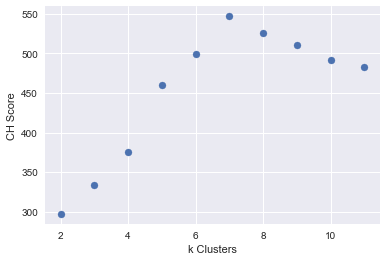

WoodDeckSF       53.658867
OpenPorchSF      29.469212
EnclosedPorch     1.818966
ScreenPorch       0.883005
PoolArea          0.000000
MasVnrArea       44.985222
dtype: float64
WoodDeckSF       210.475676
OpenPorchSF       90.589189
EnclosedPorch      1.600000
ScreenPorch        0.243243
PoolArea           0.000000
MasVnrArea       246.824324
dtype: float64
WoodDeckSF        65.225490
OpenPorchSF       55.362745
EnclosedPorch      1.725490
ScreenPorch      200.421569
PoolArea           0.000000
MasVnrArea       147.637255
dtype: float64
WoodDeckSF        47.680473
OpenPorchSF       25.420118
EnclosedPorch    173.112426
ScreenPorch        1.769231
PoolArea           0.000000
MasVnrArea        38.816568
dtype: float64
WoodDeckSF       205.571429
OpenPorchSF      104.857143
EnclosedPorch     78.857143
ScreenPorch       62.857143
PoolArea         575.428571
MasVnrArea       154.142857
dtype: float64
           SalePrice
Unnamed 0           
0             157667
1             238701
2      

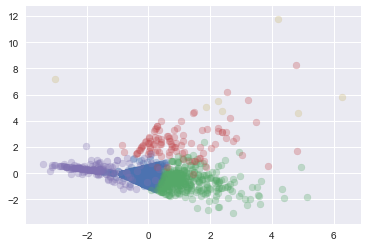

In [13]:
outdoors_clusters = cluster_analysis(X, df, outdoors, 5)

## There seems to be 5 clusters for outdoors:
-  Not much outdoors anything
-  Has enclosed porch
-  Has screen porch 
-  Has Pool + other porch areas
-  Has large wood deck

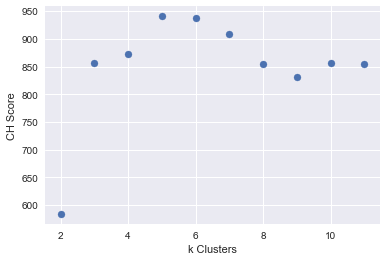

BedroomAbvGr    2.439667
KitchenAbvGr    0.998613
TotRmsAbvGrd    5.421637
Fireplaces      0.223301
dtype: float64
BedroomAbvGr    3.242560
KitchenAbvGr    1.000000
TotRmsAbvGrd    7.507440
Fireplaces      1.068452
dtype: float64
BedroomAbvGr    3.686567
KitchenAbvGr    2.029851
TotRmsAbvGrd    8.388060
Fireplaces      0.238806
dtype: float64
           SalePrice
Unnamed 0           
0             149388
1             219785
2             130451


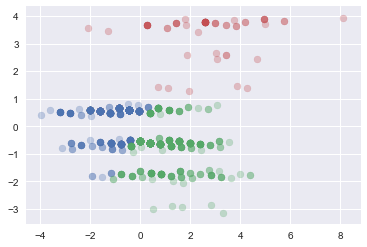

In [14]:
rooms_clusters = cluster_analysis(X, df, rooms, 3)

# There seems to be 3 clusters of rooms
-  One has 1 kitchen + 2-3 bedrooms // lowest cost
-  One has 1 kitchen, 3-4 bedrooms, and a fireplace // mid cost
-  One has 2 kitchens + 3-4 bedrooms // highest cost

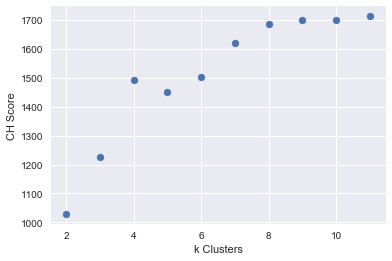

1stFlrSF     1645.236842
2ndFlrSF        3.347953
GrLivArea    1648.584795
dtype: float64
1stFlrSF     1010.830443
2ndFlrSF       16.890173
GrLivArea    1034.965318
dtype: float64
1stFlrSF      881.544248
2ndFlrSF      740.280973
GrLivArea    1625.754425
dtype: float64
1stFlrSF     1440.034014
2ndFlrSF     1102.659864
GrLivArea    2563.081633
dtype: float64
           SalePrice
Unnamed 0           
0             228354
1             130713
2             168685
3             285452


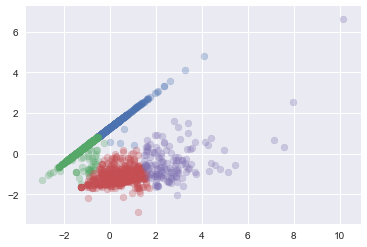

In [15]:
floors_clusters = cluster_analysis(X, df, floors, 4)

# There seems to be 4 floors clusters (in order of price)
-  Large, two floors
-  Large, one floor
-  Small, two floors
-  Small, one floor


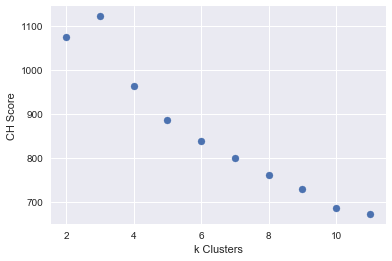

OverallQual        5.583893
OverallCond        7.211409
YearBuilt       1946.832215
YearRemodAdd    1994.174497
dtype: float64
OverallQual        7.231281
OverallCond        5.059900
YearBuilt       2000.141431
YearRemodAdd    2000.965058
dtype: float64
OverallQual        5.160428
OverallCond        5.258467
YearBuilt       1953.315508
YearRemodAdd    1962.673797
dtype: float64
           SalePrice
Unnamed 0           
0             161452
1             235796
2             132474


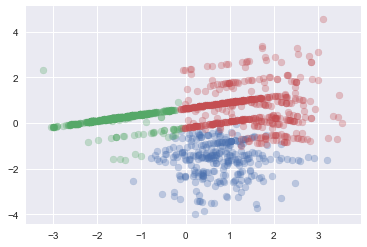

In [16]:
major_clusters = cluster_analysis(X, df, major, 3)

# There seems to be 3 clusters in the "major" list of variables
-  High quailty, recently built
-  Mid quality, recently renovated, build many years ago
-  Mid quality, build many years ago and not renovated

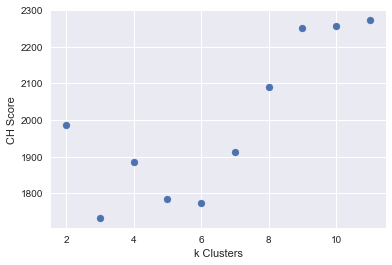

GarageYrBlt     1999.029052
YearBuilt       1997.114286
YearRemodAdd    2001.266165
dtype: float64
GarageYrBlt     1959.993103
YearBuilt       1949.647799
YearRemodAdd    1971.147170
dtype: float64
           SalePrice
Unnamed 0           
0             228269
1             141315


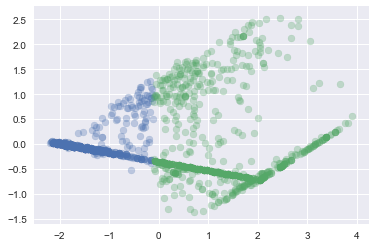

In [17]:
year_clusters = cluster_analysis(X, df, year, 2)

## Garage, year, and lot all have too few variables to do VQ.

In [18]:
the_rest = np.concatenate([lot, garage, year])

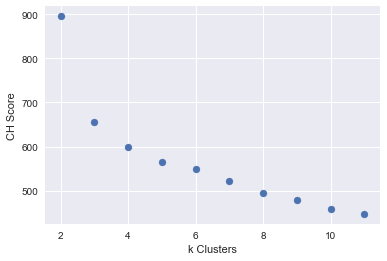

LotFrontage        73.306985
LotArea         10393.665152
GarageYrBlt      1999.373860
GarageCars          2.248485
GarageYrBlt      1999.373860
YearBuilt        1996.480303
YearRemodAdd     2000.786364
dtype: float64
LotFrontage        67.353120
LotArea         10618.437500
GarageYrBlt      1959.461859
GarageCars          1.370000
GarageYrBlt      1959.461859
YearBuilt        1950.467500
YearRemodAdd     1971.731250
dtype: float64
           SalePrice
Unnamed 0           
0             230090
1             140356


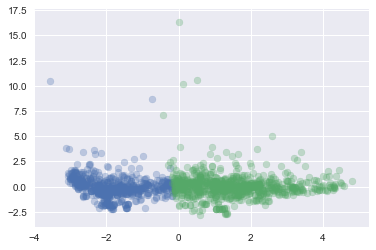

In [19]:
rest_clusters = cluster_analysis(X, df, the_rest, 2)

## The rest of the variables seem to split into two clusters
-  New, more cars/garage

-  Old

similar lot size

In [43]:
df_cluster = pd.DataFrame([basement_clusters, outdoors_clusters, 
                             rooms_clusters, floors_clusters, rest_clusters]).T

df_cluster.columns = columns=[
        "basement", "out", "rooms", "floors", "rest"
        ]
df_cluster = pd.get_dummies(df_cluster.astype(str))
df_cluster

,basement_0,basement_1,basement_2,out_0,out_1,out_2,out_3,out_4,rooms_0,rooms_1,rooms_2,floors_0,floors_1,floors_2,floors_3,rest_0,rest_1
0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0
3,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
5,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
7,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1
8,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
9,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1


In [48]:
# Add cluster categories to main dataframe
X_new = pd.concat([X, df_cluster], axis=1)
X_new = (X - X.mean()) / X.std()
X_new

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,S

## TODO: Build an estimator that
-  Fillnan of variables with NaNs (Save medians)
-  Does what modify_dataset does (drops columns we don't want AND changes a couple of variables)
-  Centers and Scales the data (Save Mean, Stds)
-  Creates k-Means models for VQ for the following (Save km models): 
    -  basement, 3
    -  outdoors, 5
    -  rooms, 3
    -  floors, 4
    -  the rest, 2
-  Put together as a single estimator into RandomForest or AdaBoost
-  Implement using GridSearchCV to find hyperparams